## <center/>使用MindSpore实现简单线性函数拟合

## 概述

回归问题算法通常是利用一系列属性来预测一个值，预测的值是连续的。例如给出一套房子的一些特征数据，如面积、卧室数等等来预测房价，利用最近一周的气温变化和卫星云图来预测未来的气温情况等。如果一套房子实际价格为500万元，通过回归分析的预测值为499万元，则认为这是一个比较好的回归分析。在机器学习问题中，常见的回归分析有线性回归、多项式回归、逻辑回归等。本例子介绍线性回归算法，并通过MindSpore进行线性回归AI训练体验。

主要流程如下：

1. 生成数据集
2. 定义前向传播网络
3. 定义反向传播网络
4. 定义线性拟合过程的可视化函数
5. 执行训练

## 环境准备

系统：Ubuntu18.04

MindSpore版本：GPU

设置MindSpore运行配置

第三方支持包：`matplotlib`，未安装此包的，可使用命令`pip install matplotlib`预先安装。

In [1]:
from mindspore import context

context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU")

`PYNATIVE_MODE`：自定义调试模式。

`device_target`：设置MindSpore的训练硬件为GPU。

## 生成数据集

### 定义数据集生成函数

`get_data`用于生成训练数据集和测试数据集。由于拟合的是线性数据，假定要拟合的目标函数为：$y=2x+3$，那么我们需要的训练数据集应随机分布于函数周边，这里采用了$y=2x+3+noise$的方式生成，其中`noise`为遵循标准正态分布规律的随机数值。

In [2]:
import numpy as np
import mindspore as ms
from mindspore import Tensor
 
def get_data(num,w=2.0, b=3.0):
    np_x = np.ones([num, 1])
    np_y = np.ones([num, 1])
    for i in range(num):
        x = np.random.uniform(-10.0, 10.0)
        np_x[i] = x
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        np_y[i] = y
    return Tensor(np_x,ms.float32), Tensor(np_y,ms.float32)

对于数据生成函数我们将有以下两个作用。

1. 生成训练数据，对模型函数进行训练。
2. 生成验证数据，在训练结束后，对模型函数进行精度验证。

### 生成测试数据

使用数据生成函数`get_data`随机生成50组验证数据，并可视化展示。

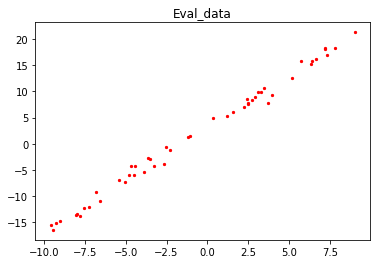

In [3]:
import matplotlib.pyplot as plt

eval_x, eval_label = get_data(50)
x1, y1 = eval_x.asnumpy(), eval_label.asnumpy()
plt.scatter(x1, y1, color="red", s=5)
plt.title("Eval_data")
plt.show()

## 定义前向传播网络

### 初始化网络模型

使用`nn.Dense`定义了网络模型，即为线性模型，

$$y=wx+b\tag{1}$$

其中，权重值$w$对应`weight`，$b$对应`bias`，并将其打印出来。

In [4]:
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn

net = nn.Dense(1,1,TruncatedNormal(0.02),TruncatedNormal(0.02))
print("weight:", net.weight.set_data([0][0]), "bias:", net.bias.set_data([0]))

weight: -0.00034249047 bias: -0.019308656


### 查看初始化的网络模型

我们将验证数据集和初始化的模型函数可视化。

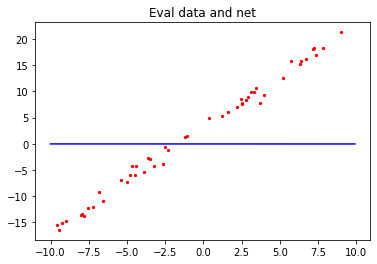

In [5]:
x = np.arange(-10, 10, 0.1)
y = x * (net.weight.set_data([0][0]).asnumpy()) + (net.bias.set_data([0]).asnumpy())
plt.scatter(x1, y1, color="red", s=5)
plt.plot(x, y, "blue")
plt.title("Eval data and net")
plt.show()

红色的点：为之前生成的50组验证数据集。

蓝色的线：初始化的模型网络。

### 定义损失函数

我们的网络模型表达式为：

$$h(x)=wx+b\tag{2}$$

一般地，数学上对线性回归模型采用均方差的方式来判断模型是否拟合得很好，即均方差的值$J(w)$值越小，函数模型便拟合得越好，验证数据代入后，预测得到的y值就越准确。公式2对应m个数据的均方差公式为：

$$J(w)=\frac{1}{m}\sum_{i=1}^m(h(x_i)-y^{(i)})^2\tag{3}$$

为了方便后续的计算，我们采用0.5倍的均方差的表达式来进行计算，均方差值整体缩小至0.5倍的计算方式对判断模型拟合的好坏没有影响。

$$J(w)=\frac{1}{2m}\sum_{i=1}^m(h(x_i)-y^{(i)})^2\tag{4}$$

公式4即为网络训练中的损失函数，其中参数：

- $J(w)$为均方差。

- $m$为样本数据的数量。

- $h(x_i)$为第$i$个数据的$x_i$值代入模型网络（公式2）后的预测值。

- $y^{(i)}$为第$i$个数据中的$y$值（label值）。

在MindSpore中定义损失函数的方法如下。

In [6]:
from mindspore.ops import operations as P

class MyLoss(nn.loss.loss._Loss):
    def __init__(self,reduction='mean'):
        super().__init__(reduction)
        self.square = P.Square()
    def construct(self, data, label):
        x = self.square(data-label) * 0.5
        return self.get_loss(x)

其中:

- `nn.loss.loss._Loss`：是MindSpore自定义loss算子的一个基类。

- `P.Square`：MindSpore训练的框架中的平方算子，算子需要注册过才能在框架的计算图中使用。

### 损失函数与网络结合

接下来我们需要将loss函数的表达式和网络net关联在一起，在MindSpore中需要`nn.WithLossCell`，实现方法如下：

In [7]:
criterion = MyLoss()
loss_opeartion = nn.WithLossCell(net, criterion) 

其中：

- `net`：网络模型。

- `criterion`：即为实例化的loss函数。

上述从数据代入到计算出loss值的过程为AI训练中的前向传播过程。

## 定义反向传播网络

有了损失函数后，我们如何使得损失函数最小呢？我们可以将公式1代入到损失函数公式4中展开：

$$J(w,b)=\frac{1}{2m}\sum_{i=1}^m(wx_i+b-y^{(i)})^2\tag{5}$$

公式5可以将$J(w)$看作为凹函数，对权重值$w$微分可求得：

$$\frac{\partial{J(w)}}{\partial{w}}=\frac{1}{m}\sum_{i=1}^mx_i(wx_i+b-y^{(i)})\tag{6}$$


由凹函数的特性可以知道，当公式6等于0时，损失函数有最小值：

$$\sum_{i=1}^mx_i(wx_i+b-y^{(i)})=0\tag{7}$$  

假设有一个$w_{min}$使得公式7成立。我们如何将初始的权重$w_{s}$逐步的变成$w_{min}$，在这里采取迭代法，也就是梯度下降方法

当权重$w_{s}<w_{min}$，那么我们需要更新权重$w_{s}$的值，将其往右移动使得权重值$w_{s}$变大，增加量为$\Delta{w}$，其中：

$$\Delta{w}=\alpha\frac{\partial{J(w_{s})}}{\partial{w}}\tag{8}$$

公式8中：

$\alpha$：表示一个系数,即深度学习中的学习率learning_rate，一般设置为正数。

$\frac{\partial{J(w_{s})}}{\partial{w}}$：表示损失函数$J(w)$在$w_{s}$的导数，可以理解为在$w_{s}$处的梯度下降率即坡度，由凹函数的性质可知，由于$w_{s}<w_{min}$，所以其值为负数。

公式8为负数，那么我们对权重值向右移动的更新公式即可以写为：

$$w_{ud}=w_{s}-\alpha\frac{\partial{J(w_{s})}}{\partial{w}}\tag{9}$$

$w_{ud}$：更新的后权重数值。

$w_{s}$：表示初始的权重。

当$w_{s}>w_{min}$，权重值需要左移即权重值变小接近$w_{min}$，才能使得损失函数逐步的变小，由凹函数的性质可知，在$w_{s}$处的导数为正（损失函数在$w_{min}$右边单调上升），公式8的值为正。其权重的更新公式为：

$$w_{ud}=w_{s}-\alpha\frac{\partial{J(w_{s})}}{\partial{w}}\tag{10}$$


当$w_{s}=w_{min}$时，到$\frac{\partial{J(w_{s})}}{\partial{w}}$=0，即梯度消失，其表达式也可写为公式9的样式。

在考虑了全区间的情况后，可以得出权重$w$的更新公式即为：

$$w_{ud}=w_{s}-\alpha\frac{\partial{J(w_{s})}}{\partial{w}}\tag{11}$$

当权重$w$在更新的过程中假如临近$w_{min}$在增加或者减少一个$\Delta{w}$，从左边或者右边越过了$w_{min}$，公式11都会使权重往反的方向移动，那么最终$w_{s}$的值会在$w_{min}$附近来回迭代，在实际训练中我们也是这样采用迭代的方式取得最优权重$w$，使得损失函数无限逼近局部最小值。

同理：对于公式5中的另一个权重$b$容易得出其更新公式为：

$$b_{ud}=b_{s}-\alpha\frac{\partial{J(b_{s})}}{\partial{b}}\tag{12}$$


当所有的权重更新完成后，将新的权重赋值给初始权重：即$w_{s}$=$w_{ud}$，$b_{s}$=$b_{ud}$。将新的初始权重传递回到模型函数中，这样就完成了反向传播的过程。

> 当遇到多项式的回归模型时，上述梯度方法也适用，由于权重数量的增加，需要将权重的名称更新为$w_0,w_1,w_2,...,w_n$，引入矩阵的表达方式，公式将会更加简洁，这里就不多介绍了。

### 实现梯度函数

在MindSpore中的所有要编入计算图的类都需要继承`nn.Cell`算子，MindSpore的梯度计算函数采用如下方式。

In [8]:
from mindspore.ops import composite as C

class GradWrap(nn.Cell):
    """ GradWrap definition """
    def __init__(self, network):
        super().__init__(auto_prefix=False)
        self.network = network
        self.weights = ms.ParameterTuple(filter(lambda x: x.requires_grad,
            network.get_parameters()))

    def construct(self, data, label):
        weights = self.weights
        return C.GradOperation(get_by_list=True) \
            (self.network, weights)(data, label)


上述代码中`GradWrap`实现的是对各个权重的微分$\frac{\partial{J(w)}}{\partial{w}}$，其展开式子参考公式6。

### 反向传播更新权重

`nn.RMSProp`为完成权重更新的函数，更新方式大致为公式11，但是考虑的因素更多，具体信息请参考[官网说明](https://www.mindspore.cn/api/zh-CN/master/api/python/mindspore/mindspore.nn.html?highlight=rmsprop#mindspore.nn.RMSProp)。

In [9]:
train_network = GradWrap(loss_opeartion) 
train_network.set_train()
optim = nn.RMSProp(params=net.trainable_params(),learning_rate=0.02)

通过以上操作，我们就完成了前向传播网络和反向传播网络的定义，接下来可以加载训练数据进行线性拟合了。

## 定义模型拟合过程可视化函数

定义一个可视化函数`plot_model_and_datasets`，将模型函数和验证数据集打印出来，观察其变化。

In [10]:
import time 

def plot_model_and_datasets(weight, bias, data_x, data_y):
    x = np.arange(-10, 10, 0.1)
    y = x * ((weight[0][0]).asnumpy()) + ((bias[0]).asnumpy())
    plt.scatter(x1,y1,color="red",s=5)
    plt.scatter(data_x.asnumpy(), data_y.asnumpy(), color="black", s=5)
    plt.plot(x, y, "blue")
    plt.axis([-11, 11, -20, 25])
    plt.show()
    time.sleep(0.02)

上述函数的参数：

- `weight`：模型函数的权重，即$w$。

- `bias`：模型函数的权重，即$b$。

- `data_x`：训练数据的x值。

- `data_y`：训练数据的y值。

> 可视化过程中，红色的点是验证数据集，黑色的点是单个batch的训练数据，蓝色的线条是正在训练的回归模型。

## 执行训练

其训练过程如下：

1. 设置训练的迭代次数`step_size`。
2. 设置单次迭代的训练数据量`batch_size`。
3. 正向传播训练`grads`。
4. 反向传播训练`optim`。
5. 图形展示模型函数和数据集。
6. 清除本轮迭代的输出`display.clear_output`，起到动态可视化效果。

迭代完成后，输出网络模型的权重值$w和b$。

loss_value: 0.42879593


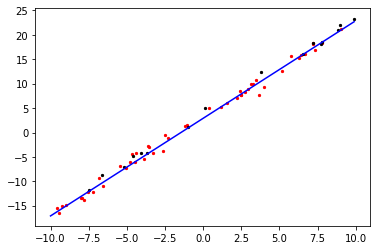

weight: 1.9990227 bias: 2.9115517


In [11]:
from IPython import display

step_size = 200
batch_size = 16

for i in range(step_size):
    data_x,data_y = get_data(batch_size)
    grads = train_network(data_x,data_y) 
    optim(grads)
    plot_model_and_datasets(net.weight.data, 
                            net.bias.data, data_x, data_y)
    display.clear_output(wait=True)

output = net(eval_x)
loss_output = criterion(output, eval_label)
print("loss_value:", loss_output.asnumpy())
plot_model_and_datasets(net.weight.data, net.bias.data, data_x,data_y)
print("weight:", net.weight.set_data([0][0]), "bias:", net.bias.set_data([0]))

可以看到最终得到的线性拟合的权重值非常接近目标函数权重weight=2、bias=3。

## 总结

本次体验我们了解了线性拟合的算法原理，并在MindSpore框架下实现了相应的算法定义，了解了线性拟合这类的线性回归模型在MindSpore中的训练过程，并最终拟合出了一条接近目标函数的模型函数。另外有兴趣的可以调整数据集的生成区间从（-10,10）扩展到（-100,100），看看权重值是否更接近目标函数；调整学习率大小，看看拟合的效率是否有变化；当然也可以探索如何使用MindSpore拟合$f(x)=ax^2+bx+c$这类的二次函数或者更高次的函数。